In [ ]:
!pip install nelson_siegel_svensson

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install datetime


In [ ]:
!pip install yahoo_fin

### **Implementation of the Heston Model for option pricing**

The main improvement from the BSM model to the Heston pricing model is to take care of the non constant volatility problem that arise from the BSM model. 
The BSM model, famously known for the analytical solutions for the call and put values it provides, assumes a constant interest rate and constant volatility of the underlying price. 
For a short term strategy, the constant interest rate, even though incorrect, is less problematic than the constant volatility which grealty influences both the underlying price moves and option value. 

Heston model's fundation is the two PDE establishing two geometric brownian motions for the asset price and asset volatility.  

# **Defining the different steps of the process:**

There are several bricks to lay for the classical implementation of the Heston model that we are going to cover here: 

> **Expression of the model closed form solution** for the call and put fair value. The expression provided by Heston is derived from the 2 main PDE (on the underlying asset price and the volatility), from Itô Lemma for a 3 variable problem and from the risk neutral expression of the call and put payoff. This is going to give us the expression of Garman's differential equation.



>Building the solution to Garman's equation **passing by the characteritic equation method**. As shown below, the arbitrage value of an attaignable call option or put option uses, in its integral form, the probability density function of the underlying price. Unfortunaltely, the pdf is not often in close form, whereas the characteristic function is. This is the reason why Heston uses the characteristic function method to get to his system equation solution.

> **Obtaining a numerical solution**, once this characteristic function is known, is done through the **Fast Fourrier algorithm**. The fundamental insight of Fourier based option pricing (which is used in many models outside of the Heston and BSM), is the replace both the pdf by the characteristic function and the call/put option payoff by its Fourier transform. We are going to follow the Carr Maddan approach here for this FFT implementation.

> Once the numerical process is flowing well and that we can apply data to it, one important step left is to proceed to the **model parameter calibration**. Here we are going to use the maximum likelihood method and a simple scipy mean error optimizer.


# **Model's Fundamental Partial Differential Equations:**
The Heston model establishes two geometric Brownian motions equations for the variation of the underlying price and the underlying price volatility. 

# **(1)  For the price (St) stochastic process** :
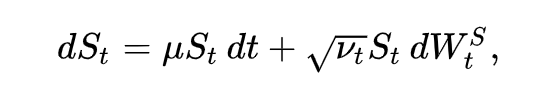

# **(2) For the volatility (sqrt (vt) ) stochastic process:**


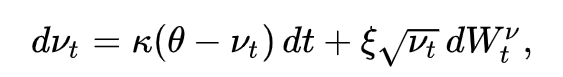

Parameters 
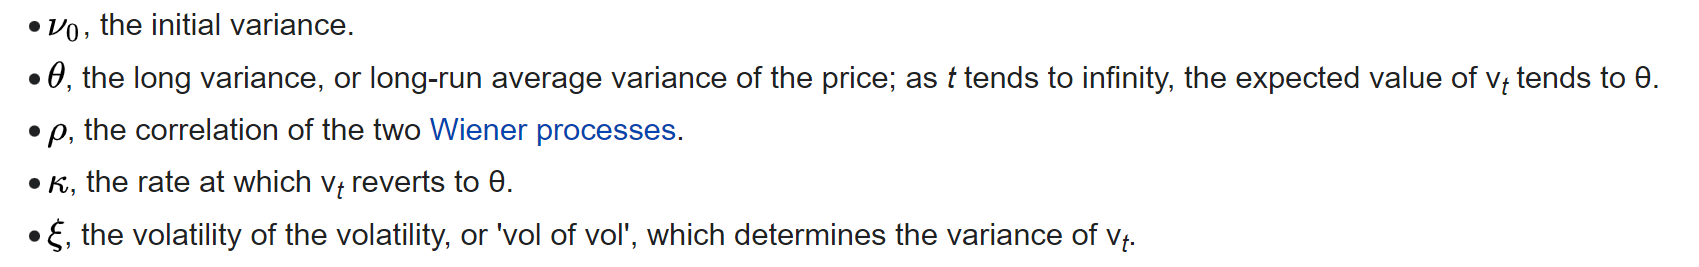

# **Garman's differential equation**

Taking Itô Lemma for a tree variables function, we can arrive to the Garman PDE that gives a closed form differential equation for the variation of a call or put value. We are going to describe the equations for the call values but we can later draw the equivalent put value formula and train the model also for put values. 


Let's take a quick look at Itô Lemma for a one variable stochastic process of variable Xt, evolving according to time t only: 
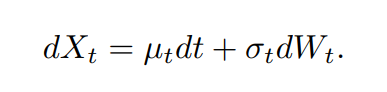 

The PDE describing a function of this variable Xt and t (like a option valuation funciton) will then be found through the approximation by Taylor expansion: 

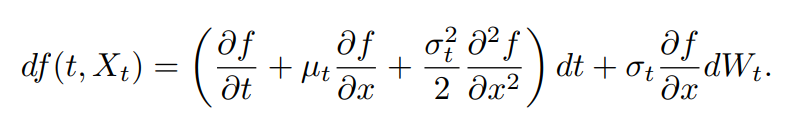

This is what we have in the BSM model


Now let's apply this Taylor expansion to a three variable function: Xt, t and Vt, with Vt that is going to measure the volatility stochastic process, and let's see the equation we obtain: 

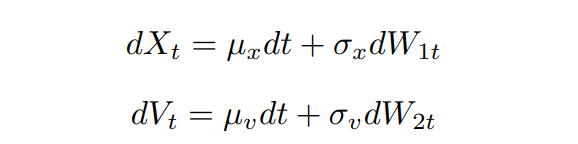

General Expression of Itô for a three variable function: 

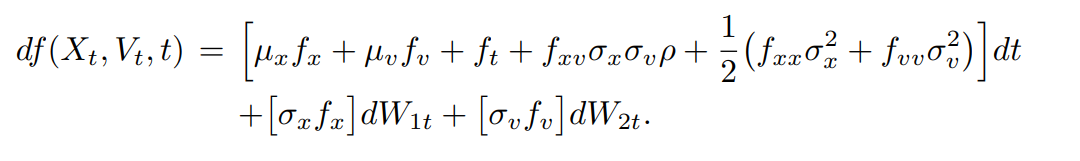

You can find the details of the development of a three variable Taylor expansion in the apendix of the paper listed in (**)


Let's substitute the different variable there by our call valuation variables at play: 


> -The underlying price St: substituting Xt

> -The underlying price drift: (r-q) : interest rate minus the dividend substituting for the variable μx

> -The volatility drift [k (θ - Vt) - λ*Vt] substituting for μv

> -The theta of the call value substituting for ft

> -The delta of the call value with regards to St substituting for fx

> -The gamma of the call value with regards to St substituting for fx,x

> -The delta of the call value with regards to Vt substituting for fv,

> -The gamma of the call value with regards for Vt substituting for fv,v
and finally the gamma value for the call value with regards to Vt and St substituting for fx,v multiplied by the two std of St and Vt as well as the correlation factor between the two Brownian motion.

We can then obtain **Garman's equation**: 

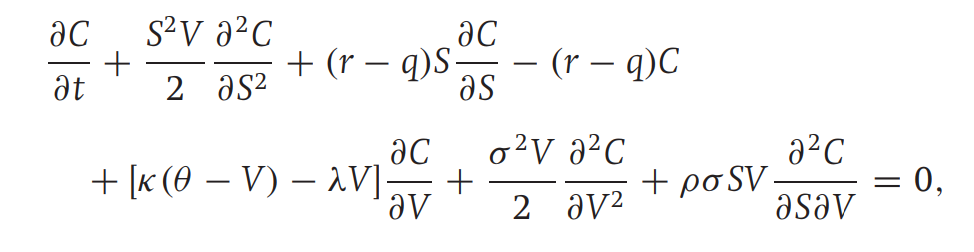

This function involves two Brownian motions and does not have, as we said, a simple analytical solution like in the BSM model. 
Thus, instead of a direct solution, Heston build the solution of this PDE through the method of characteristic function. 



The problem we have at hand here is that we do not have a simple expression for the probability density function (pdf) of this option valuation function. This is why we resort the the characteristic function method and the Fourier transform  

**Fourier Transfom gives us a method for for the characteristic function**

Let a random variable X be distributed with the pdf q(x). The characteristic function q_hat of X is the Fourier transform of its pdf: 

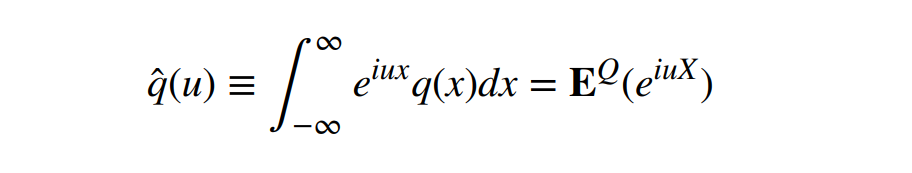



The characteristic function for a random variable x is defined by the following general formula: 

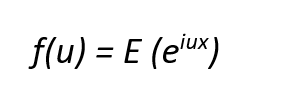

Heston presented this characteristic function in a way that allowed him to express his solution in the form corresponding to a BSM model:

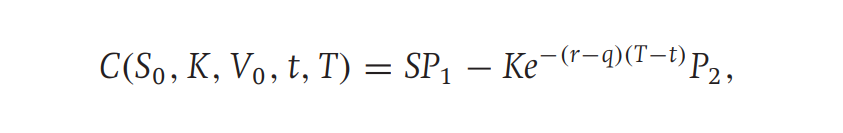

where P1 is the delta of the call option (European call) and P2 the conditional risk neutral probability that the asset price will be higher that the strike (so that the option will be exerciced). We can find back the unique characteristic function of this model from the expression of P1 and P2 

The general form for P1 and P2 is: 

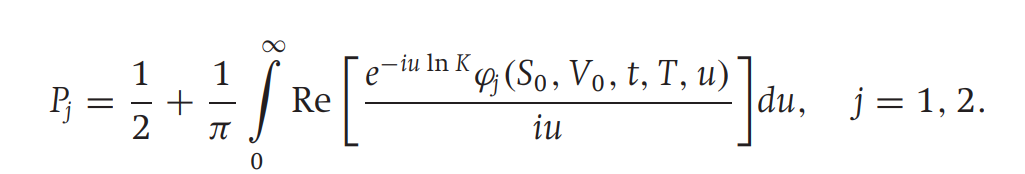

The terms P1 and P2 satisfy the preceeding PDE provided that the characteristic function ρ1 and ρ2 are knows. ρ1 and ρ2 generalize under the function ρ that takes the following form:


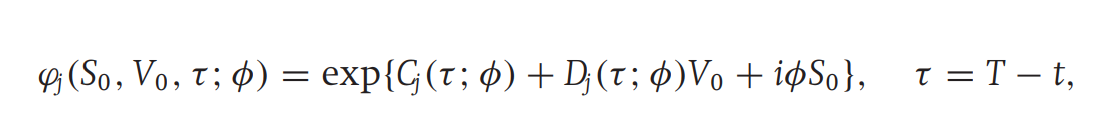




Below are the PDE corresponding to Cj and Dj :

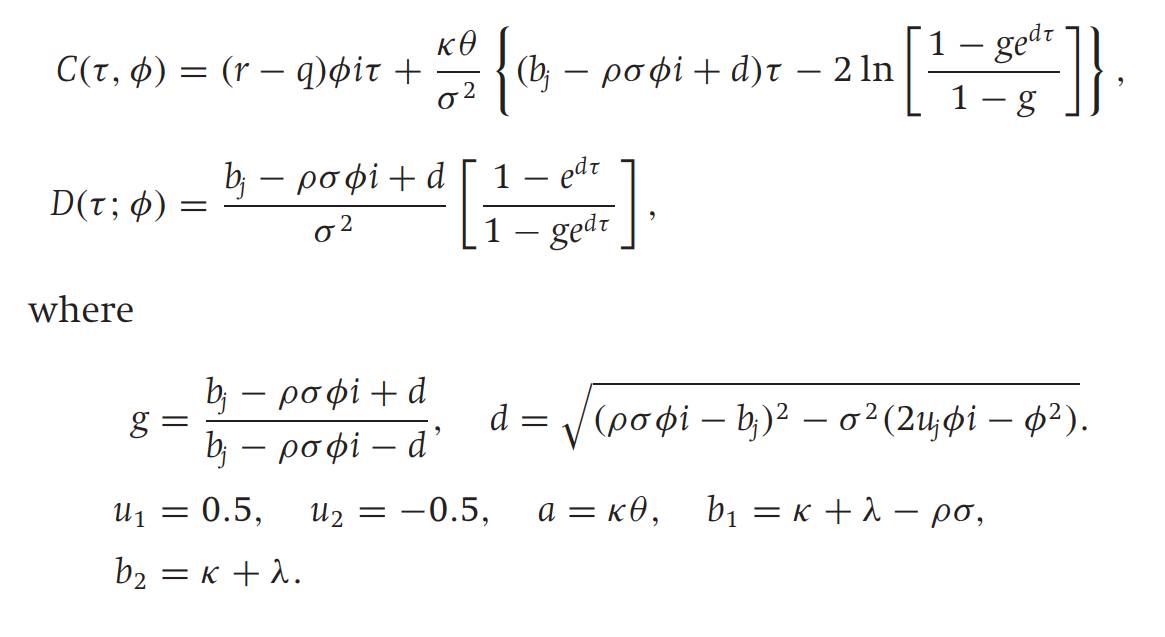

One more transformation to make to arrive at Heston's solution is to convert the asset price St to Xt being the log of St: 
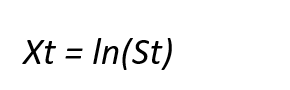

We can then write the full expression for Pj being: 

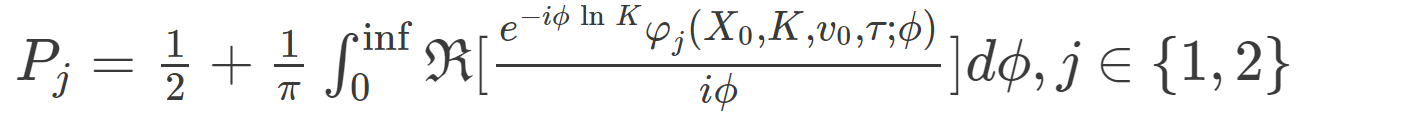

In the formulas for Cj and Dj, after rearranging the values for bj and uj (b1 and b2 and u1 and u2), we can find that function ρ1 and ρ2 can actually be related to the same ρ function with different argument. More precisely; for the same real variable x: 

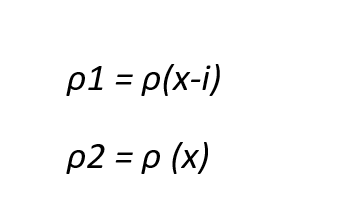

This enable then to give the following expressions for P1 and P2: 


P1 : 

>  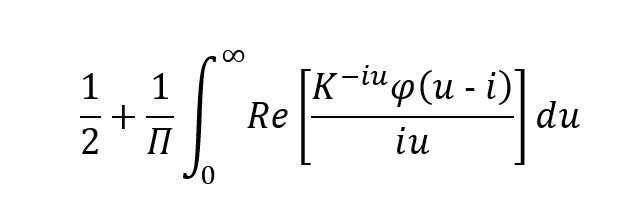


P2: 

> 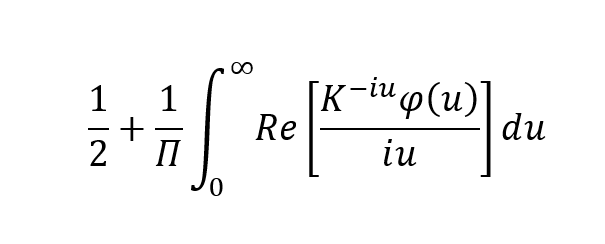



From these 2 expressions, the function for the call valuation becomes: 
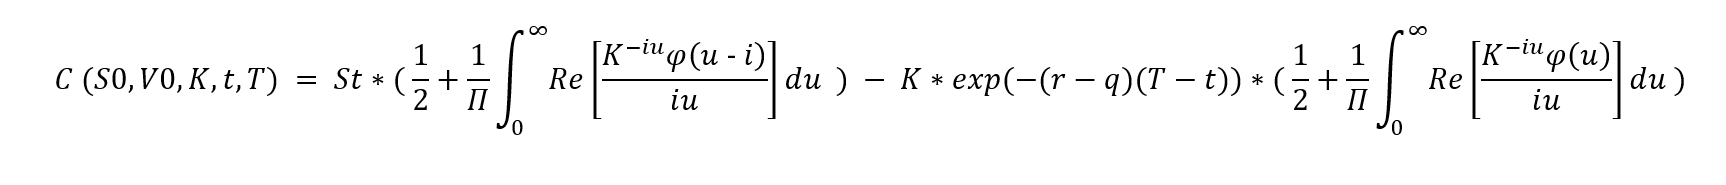

  For simplicity, from now on, we will consider there is no dividends so q = 0, and we will note T-t = τ : 

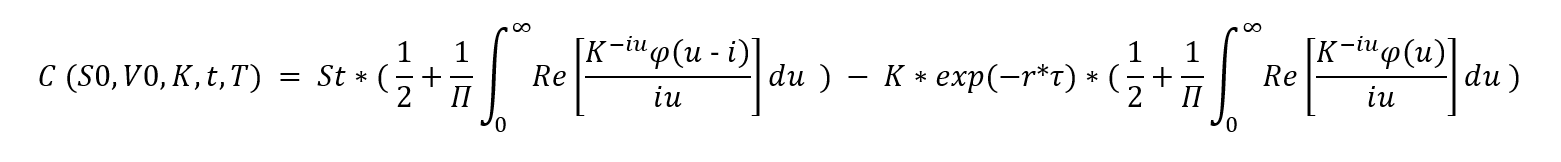


We transform this formula to get only one integral to express: 

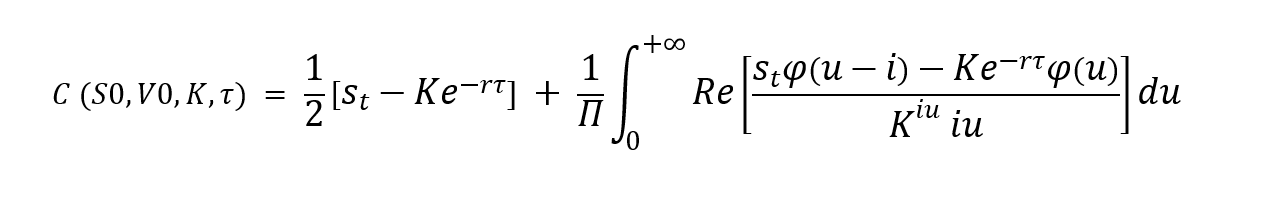

We can also lay out the expression for the function ρ: 

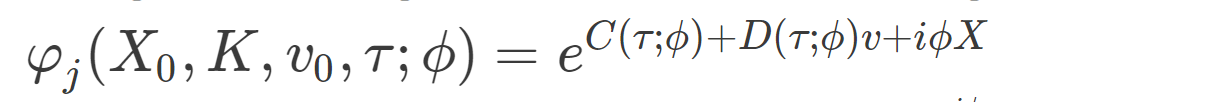


We can define some intermediary variables to simplify the final expression and cut down the exp into several pieces: 
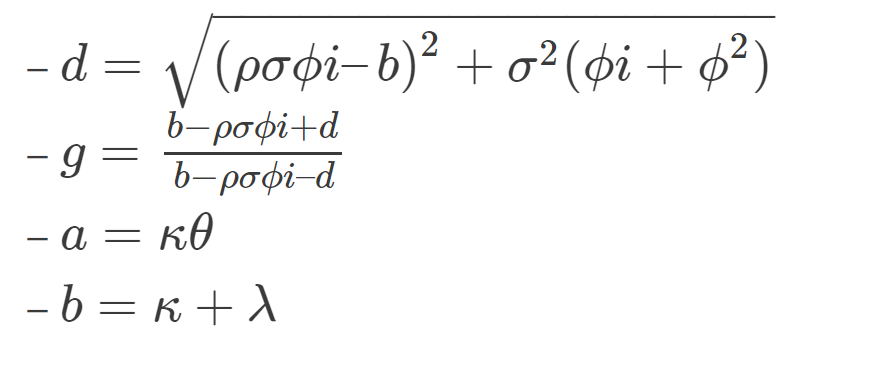


The resulting characteristic function becomes:


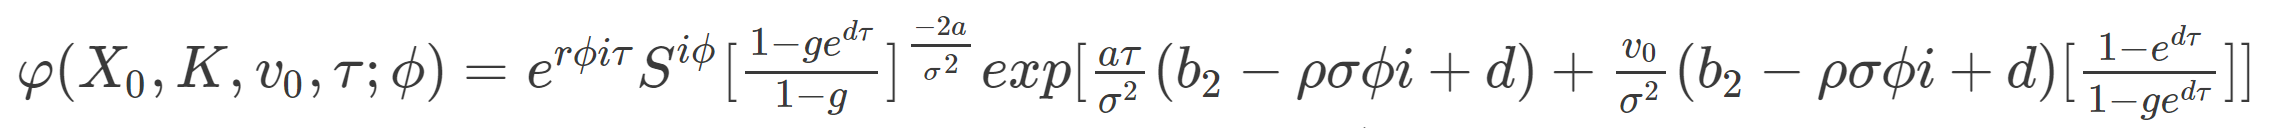

We can then proceed to coding the functions we need:

> -the characteristic function


> The integral calculation


> The heston call price from the integral and charasteristic function






Final expression of the call price after re arranging the integral part:

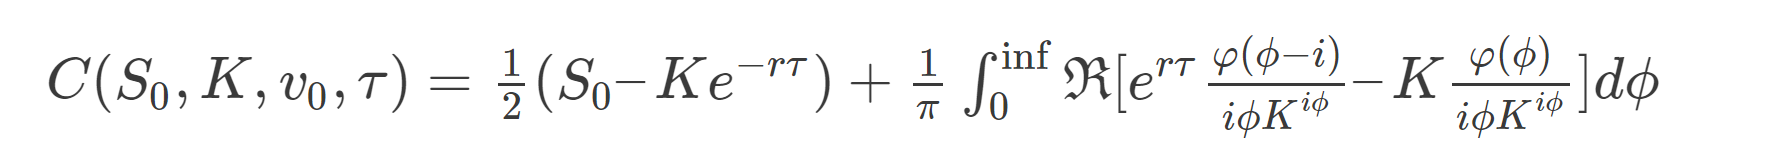

In [ ]:
from yahoo_fin.stock_info import get_data
import yahoo_fin.options as ops
import os
import numpy as np
import datetime as dt
from datetime import timedelta
import pandas as pd

In [ ]:
# heston characteristic function


def heston_char(phi, S0, V0, sigma, kappa, tau, lambd, r, rho, theta):
  # we define some intermediary variables to simplify the final expression:
  b = kappa + lambd
  d = np.round(np.sqrt((rho*sigma*phi*1j - b)**2 - (phi*1j - phi**2)*sigma**2), 4)
  g = np.round((b- rho*sigma*phi*1j + d) / (b - rho*sigma*phi*1j - d),4)
  a = kappa*lambd

  term1 = np.round(np.exp(r*phi*1j*tau), 4)
  term2 = np.round(S0**(1j*phi), 4)
  f1 = np.round(np.exp(d*r), 4)
  f2 = np.round((1 - g*f1)/(1-g), 4)
  term3 = np.round(f2**(-2*a/(sigma**2)), 4)
  f3 = np.round(b - rho*sigma*phi*1j + d, 4)
  f4 = np.round(a*tau/(sigma**2), 4)
  f5 = np.round((1-f1)/(1-g*f1), 4)
  term4 = np.round(np.exp(f4*f3 + (V0/sigma**2)*f3*f5), 4)

  # we bring the different pieces together:

  return term1*term2*term3*term4

In [ ]:
# define the integral and make integration by rectangular series
def heston_price(K, S0, V0, sigma, kappa, tau, lambd, r, rho, theta):
    args = (S0, V0, kappa, theta, sigma, rho, lambd, tau, r)
    
    P, umax, N = 0, 100, 10000
    dphi=umax/N #dphi is width
    for i in range(1,N):
        # rectangular integration
        phi = dphi * (2*i + 1)/2 # midpoint to calculate height
        numerator = np.exp(r*tau)*heston_char(phi-1j,*args) - K * heston_char(phi,*args)
        denominator = 1j*phi*K**(1j*phi)
        
        P += dphi * numerator/denominator
        
    return np.real((S0 - K*np.exp(-r*tau))/2 + P/np.pi)

In [ ]:
# try with our formula: NO GOOD

def heston_price_own(K, S0, V0, sigma, kappa, tau, lambd, r, rho, theta):
    args = (S0, V0, kappa, theta, sigma, rho, lambd, tau, r)
    
    P, umax, N = 0, 100, 10000
    dphi=umax/N #dphi is width
    for i in range(1,N):
        # rectangular integration
        phi = dphi * (2*i + 1)/2 # midpoint to calculate height
        numerator = heston_char(phi-1j,*args) - K *np.exp(r*tau)* heston_char(phi,*args)
        denominator = 1j*phi*K**(1j*phi)
        
        P += dphi * numerator/denominator
        
    return np.real((S0 - K*np.exp(-r*tau))/2 + P/np.pi)

We will use the scipy package to perform the integral calculation.
We cannot integrate up until infinity so we will set an upper bound 

In [ ]:
# set of parameters and data to test the model

S0 = 223 # initial asset price
V0 = 0.04 # initial vol
K = 50 # strike
r = 0.05 # risk free rate 
sigma = 0.27 # vol of vol
kappa = 1.34 # mean reversion rate for long term variance
theta = 0.15 # long term variance
lambd = 0.576 # risk premium of variance
tau = 10
rho = -0.56


In [ ]:
test = heston_price(K = K,
                  S0 = S0,
                  V0 = V0,
                  r = r, 
                  sigma = sigma, 
                  theta = theta, 
                  lambd = lambd,
                  tau = tau, 
                  rho = rho, 
                  kappa = kappa)

print(test)

152.63025267144718


In [ ]:
from nelson_siegel_svensson import NelsonSiegelSvenssonCurve, NelsonSiegelCurve
from nelson_siegel_svensson.calibrate import calibrate_ns_ols, calibrate_nss_ols

In [ ]:
# GET INTEREST RATE CURVE FROM US YIELD CURVE

def get_yield_curve(treasury_yield_path = "/content/drive/MyDrive/daily-treasury-rates.csv", rate_date=None):
  us_yield = pd.read_csv(treasury_yield_path, index_col='Date', parse_dates=True).sort_index(ascending=False)
  mat = {'Mo': 12,
       'Yr': 1}
  if rate_date is None:
    yields_dict = us_yield.iloc[0, :].to_dict()
  else:
    yields_dict = us_yield.iloc[rate_date, :].to_dict()
  for i in yields_dict.keys():
    if i.split(' ')[1] not in mat.keys():
      yields_dict.pop(i)
  yield_maturities = np.array([int(i.split(' ')[0])/mat[i.split(' ')[1]] for i in yields_dict.keys()])
  yields = np.array([*yields_dict.values()]).astype(float)/100
  return yields, yield_maturities


yields, yield_maturities = get_yield_curve()

In [ ]:
curve_fit, status = calibrate_nss_ols(yield_maturities,yields) 
curve_fit

NelsonSiegelSvenssonCurve(beta0=0.040005979889915944, beta1=-0.012893785645614107, beta2=0.029981691583237404, beta3=-0.0014204370679723444, tau1=0.3943212691506386, tau2=4.634433301748445)

In [ ]:
# LOAD OPTION PRICE AND STOCK PRICE DATA

price_ref = 'adjclose'
period = 10
 # list of tickers

corp_tickers = ['TSLA', 'AMZN', 'AAPL', 'MSFT', 'DIS']
call_df = []
for ticker in corp_tickers:
  expi = ops.get_expiration_dates(ticker)[1:]
  df = get_data(ticker=ticker, start_date=(dt.datetime.now()-timedelta(days = 60)).strftime('%d/%m/%Y'), end_date=None, index_as_date=None)
  st_dict = df.set_index('date').to_dict()[price_ref] # should we take the close ? 
  df["returns"] = df[price_ref].pct_change(1)
  df["V0"] = df["returns"].rolling(period).std()
  df = df.dropna(subset=["V0"])
  v0_dict = df.set_index('date').to_dict()["V0"]
  for i in expi:
    try:
      a = ops.get_calls(ticker, dt.datetime.strptime(i, "%B %d, %Y").strftime('%d/%m/%Y'))
      a["Maturity"] = a["Contract Name"].apply(lambda x: dt.datetime.strptime(x.split('C')[0].split(ticker)[1], "%y%m%d"))
      a["Last Trade Date"] = a["Last Trade Date"].apply(lambda x : dt.datetime.strptime(x.split(' ')[0],'%Y-%m-%d')) 
      a['Tau'] = a['Maturity'] - a['Last Trade Date']
      a["S0"] = a['Last Trade Date'].map(st_dict) 
      a = a.dropna(subset=['S0'])
      a["V0"] = a['Last Trade Date'].map(v0_dict)
    except ValueError : 
      a = None 
      print('No table found for expi date: {}'.format(str(i)))  
    call_df.append(a)
    
call_df = pd.concat(call_df)

# add r to the call_df df
my_yield_maturities = np.array(call_df['Tau']/ (dt.timedelta(days=1)*365))
call_df["r_forward"] = NelsonSiegelSvenssonCurve.forward(curve_fit,my_yield_maturities)
call_df['r_zeros'] = NelsonSiegelSvenssonCurve.zero(curve_fit,my_yield_maturities)


No table found for expi date: November 4, 2022
No table found for expi date: December 2, 2022
No table found for expi date: November 4, 2022


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


No table found for expi date: December 2, 2022
No table found for expi date: November 4, 2022
No table found for expi date: December 2, 2022
No table found for expi date: November 4, 2022
No table found for expi date: December 2, 2022
No table found for expi date: November 4, 2022
No table found for expi date: December 2, 2022


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
call_df

,Contract Name,Last Trade Date,Strike,Last Price,Bid,Ask,Change,% Change,Volume,Open Interest,Implied Volatility,Maturity,Tau,S0,V0,r_forward,r_zeros
0,TSLA221028C00100000,2022-10-17,100.0,113.55,119.8,120.45,0.00,-,15,19,143.75%,2022-10-28,11 days,219.350006,0.043739,0.030175,0.028677
1,TSLA221028C00110000,2022-10-17,110.0,109.95,109.8,110.35,0.00,-,4,4,189.65%,2022-10-28,11 days,219.350006,0.043739,0.030175,0.028677
2,TSLA221028C00120000,2022-10-17,120.0,94.05,99.7,100.4,0.00,-,3,35,172.66%,2022-10-28,11 days,219.350006,0.043739,0.030175,0.028677
3,TSLA221028C00130000,2022-10-17,130.0,88.35,89.95,90.5,0.00,-,1,23,133.20%,2022-10-28,11 days,219.350006,0.043739,0.030175,0.028677
4,TSLA221028C00140000,2022-10-19,140.0,82.45,80.0,80.55,8.25,+11.12%,6,25,122.07%,2022-10-28,9 days,220.070007,0.041292,0.029647,0.028403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20,DIS250117C00155000,2022-10-18,155.0,7.40,6.9,7.65,0.00,-,2,60,36.41%,2025-01-17,822 days,98.480003,0.022442,0.040105,0.042638
21,DIS250117C00160000,2022-10-18,160.0,6.85,6.05,6.85,0.70,+11.38%,7,62,36.12%,2025-01-17,822 days,98.480003,0.022442,0.040105,0.042638
22,DIS250117C00165000,2022-10-18,165.0,6.00,5.45,6.45,0.00,-,1,107,36.51%,2025-01-17,822 days,98.480003,0.022442,0.040105,0.042638
23,DIS250117C00170000,2022-10-19,170.0,4.80,4.65,5.5,-0.55,-10.28%,4,88,35.61%,2025-01-17,821 days,98.930000,0.022513,0.040109,0.042641


In [ ]:
import re 
# get the ticker name:
call_df["ticker_name"] = call_df["Contract Name"].apply(lambda x: re.split('\d', x)[0] )

In [ ]:
call_df["ticker_name"] 

0     TSLA
1     TSLA
2     TSLA
3     TSLA
4     TSLA
      ... 
20     DIS
21     DIS
22     DIS
23     DIS
24     DIS
Name: ticker_name, Length: 5665, dtype: object

In [ ]:
from scipy.optimize import minimize 

In [ ]:
# perform the optimization of the parameters

# we will use the same integration function that uses the rectangular integration technique
# here we will apply it to the loss function derivated according to all the params

# Parameters are v0, kappa, theta, sigma, rho, lambd
# x0 is an initialization vector
P = call_df['Last Price']
params = {"v0": {"x0": 0.2, "bounds": [1e-2,0.3]}, 
          "kappa": {"x0": 2, "bounds": [1e-2,5]},
          "theta": {"x0": 0.15, "bounds": [1e-2,0.3]},
          "sigma": {"x0": 0.3, "bounds": [1e-2,1]},
          "rho": {"x0": -0.8, "bounds": [-1,0]},
          "lambd": {"x0": 0.03, "bounds": [-1,1]},
          }


x0 = [param["x0"] for key, param in params.items()]
bounds = [param["bounds"] for key, param in params.items()]

def SqErr(x):
    v0, kappa, theta, sigma, rho, lambd = [param for param in x]
    # Decided to use rectangular integration function in the end
    err = np.sum( (P-heston_price(S0, K, v0, kappa, theta, sigma, rho, lambd, tau, r))**2 /len(P) )
    # Zero penalty term - no good guesses for parameters
    pen = 0 #np.sum( [(x_i-x0_i)**2 for x_i, x0_i in zip(x, x0)] )
          
    return err + pen

#result = minimize(SqErr, x0, tol = 1e-3, method='L-BFGS-B’, options={'maxiter': 1e3 }, bounds=bounds) 
result = minimize(SqErr, x0, tol = 1e-3, method='SLSQP', options={'maxiter': 1e3 }, bounds=bounds)
v0, kappa, theta, sigma, rho, lambd = [param for param in result.x]





In [ ]:
# bid ask here is not used but may be interesting info to retain in call_df



x_sample = call_df[['Strike', 'Tau', 'S0', 'V0', 'r_forward', 'r_zeros', 'ticker_name']]
y = call_df['Last Price']
x_sample['Tau'] = pd.to_numeric(x_sample['Tau'].dt.days, downcast='integer')
x_sample
# one thing to add to x_sample would be the interest rate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,Strike,Tau,S0,V0,r_forward,r_zeros,ticker_name
0,100.0,11,219.350006,0.043739,0.030175,0.028677,TSLA
1,110.0,11,219.350006,0.043739,0.030175,0.028677,TSLA
2,120.0,11,219.350006,0.043739,0.030175,0.028677,TSLA
3,130.0,11,219.350006,0.043739,0.030175,0.028677,TSLA
4,140.0,9,220.070007,0.041292,0.029647,0.028403,TSLA
...,...,...,...,...,...,...,...
20,155.0,822,98.480003,0.022442,0.040105,0.042638,DIS
21,160.0,822,98.480003,0.022442,0.040105,0.042638,DIS
22,165.0,822,98.480003,0.022442,0.040105,0.042638,DIS
23,170.0,821,98.930000,0.022513,0.040109,0.042641,DIS


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from collections import OrderedDict
from sklearn.model_selection import train_test_split

In [ ]:
# let's try a convolutional neural net

D_in = 1
D_out = 1

class CNet(nn.Module):
  def __init__(self, D_in, D_out, q_1, q_2):
    super(CNet, self).__init__()
    self.D_in = D_in
    self.D_out = D_out
    self.q_1 = q_1
    self.q_2 = q_2
    self.conv1 = nn.Conv2d(self.D_in, )

    self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    

In [ ]:
# set up a neural net from the X sample data:

# We ll set up a simple multi layer perceptron using pytorch sequential functionality

# let's try increasing the number of neurons 

class SimpleMLP(nn.Module):
  def __init__(self, input_size, output_size=1, q_1 = 20, weight_decay = 0, lr=0.001):
    super(SimpleMLP, self).__init__()
    self.D_in = input_size # nb of features in X
    self.D_out = output_size  # nb of features predicted for y
    self.q_1 = q_1 # number of neurons in the layer
    # initialization of optimizer and loss
    self.lr = lr
    self.weight_decay = weight_decay

    self.my_net = nn.Sequential(OrderedDict([('linear1', nn.Linear(self.D_in, self.q_1)),
                                    ('relu1', nn.ReLU()),

                                     ('linear2', nn.Linear(self.q_1, self.D_out)), 

                                  ]))
    
  

    
    self.optimizer = optim.Adam(self.my_net.parameters(), lr=self.lr,weight_decay=self.weight_decay)
    self.loss = nn.MSELoss()

    



In [ ]:
X = torch.from_numpy(np.array(x_sample))
y = torch.from_numpy(np.array(y))[:, None]
X.shape[1]

6

In [ ]:
y.shape

torch.Size([2843, 1])

In [ ]:
y[1]

tensor(254.5000, dtype=torch.float64)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle=False)

In [ ]:
X_train.shape
X_test.shape
y_train.shape


torch.Size([2274])

In [ ]:
y_test.shape

torch.Size([569])

In [ ]:
y_train[1]

tensor(254.5000, dtype=torch.float64)

In [ ]:
my_mlp = SimpleMLP(input_size = X.shape[1] , output_size = 1 , q_1 = 50, lr=0.015, weight_decay=0)
model = my_mlp.my_net
loss_fn = my_mlp.loss
optimizer = my_mlp.optimizer

In [ ]:
# training loop
def training_loop(n_epoch, X_train, y_train, model, loss_function, optimizer):
  loss_series = []
  for epoch in range(n_epoch):
    output = model(X_train)
    l = loss_function(output, y_train)
    # print stats
    savedLoss = 0.0
    savedLoss +=l.item()
    loss_series.append(savedLoss)
    if epoch % 100 == 99:
      print('[%d, %2d] loss: %.3f' % (epoch-99, epoch + 1, l))
    optimizer.zero_grad()
    l.backward()
    optimizer.step() #weight update step
  
  
  return output, l


In [ ]:
pred, loss_series = training_loop(n_epoch=5000, X_train=X_train.float(), y_train=y_train.float(), model=model, loss_function=loss_fn, optimizer = optimizer)



[0, 100] loss: 13478.034
[100, 200] loss: 12800.071
[200, 300] loss: 12546.490
[300, 400] loss: 12224.464
[400, 500] loss: 11947.476
[500, 600] loss: 11640.227
[600, 700] loss: 11268.367
[700, 800] loss: 10865.803
[800, 900] loss: 10479.437
[900, 1000] loss: 9852.827
[1000, 1100] loss: 9292.314
[1100, 1200] loss: 8936.403
[1200, 1300] loss: 8311.242
[1300, 1400] loss: 7971.705
[1400, 1500] loss: 7528.493
[1500, 1600] loss: 7200.324
[1600, 1700] loss: 7732.861
[1700, 1800] loss: 5582.442
[1800, 1900] loss: 4862.335
[1900, 2000] loss: 4598.845
[2000, 2100] loss: 4474.605
[2100, 2200] loss: 4499.563
[2200, 2300] loss: 4159.297
[2300, 2400] loss: 4063.621
[2400, 2500] loss: 3988.887
[2500, 2600] loss: 4350.626
[2600, 2700] loss: 3855.074
[2700, 2800] loss: 3795.788
[2800, 2900] loss: 3750.936
[2900, 3000] loss: 3750.736
[3000, 3100] loss: 3755.647
[3100, 3200] loss: 3753.360
[3200, 3300] loss: 3681.400
[3300, 3400] loss: 4009.935
[3400, 3500] loss: 3733.166
[3500, 3600] loss: 3598.002
[360

In [ ]:
pred

tensor([[225.0637],
        [346.2751],
        [113.1691],
        ...,
        [ 19.4684],
        [ 14.5472],
        [  7.7078]], grad_fn=<AddmmBackward0>)

In [ ]:
y_train

tensor([[206.0500],
        [254.5000],
        [173.9000],
        ...,
        [ 26.6000],
        [ 25.7000],
        [ 25.3200]], dtype=torch.float64)

In [ ]:
# Load the generic minimization function from scipy
from scipy.optimize import minimize

# Create a new function to return the negative of the loglikelihood
nile_model_2 = LocalLevel(nile)
def neg_loglike(params):
    return -nile_model_2.loglike(params)

# Perform numerical optimization
output = minimize(neg_loglike, nile_model_2.start_params, method='Nelder-Mead')

print(output.x)  # [ 15108.31   1463.55]
print(nile_model_2.loglike(output.x))  # -632.537685587